In [1]:
!wget https://datasets.simula.no/downloads/kvasir-seg.zip

--2023-02-13 09:39:12--  https://datasets.simula.no/downloads/kvasir-seg.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46227172 (44M) [application/zip]
Saving to: ‘kvasir-seg.zip’

kvasir-seg.zip      100%[===================>]  44.08M  60.9MB/s    in 0.7s    

2023-02-13 09:39:13 (60.9 MB/s) - ‘kvasir-seg.zip’ saved [46227172/46227172]



In [2]:
!unzip -qq kvasir-seg.zip

In [3]:
from torch.nn import ConvTranspose2d, Conv2d, MaxPool2d, Module, ModuleList, ReLU, BCEWithLogitsLoss
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch
import os

from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import cv2

In [5]:
# base path of the dataset
DATASET_PATH = os.path.join("Kvasir-SEG")
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")
# define the test split
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
PIN_MEMORY = True if DEVICE == "cuda" else False

In [8]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 3
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 200
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [9]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

In [10]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [11]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [12]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [13]:
class UNet(Module):
  def __init__(self, encChannels=(3, 16, 32, 64),
    decChannels=(64, 32, 16),
		nbClasses=1, retainDim=True,
		outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
      super().__init__()
      # initialize the encoder and decoder
      self.encoder = Encoder(encChannels)
      self.decoder = Decoder(decChannels)
      # initialize the regression head and store the class variables
      self.head = Conv2d(decChannels[-1], nbClasses, 1)
      self.retainDim = retainDim
      self.outSize = outSize
  def forward(self, x):
		# grab the features from the encoder
    encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0],encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
    map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
		# return the segmentation map
    return map

In [15]:
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [16]:
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] found 850 examples in the training set...
[INFO] found 150 examples in the test set...


In [17]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [18]:
import time

In [19]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  0%|          | 1/200 [00:15<51:15, 15.45s/it]

[INFO] EPOCH: 1/200
Train loss: 0.585056, Test loss: 0.7009


  1%|          | 2/200 [00:23<36:49, 11.16s/it]

[INFO] EPOCH: 2/200
Train loss: 0.482489, Test loss: 0.6600


  2%|▏         | 3/200 [00:32<33:04, 10.07s/it]

[INFO] EPOCH: 3/200
Train loss: 0.441717, Test loss: 0.6182


  2%|▏         | 4/200 [00:40<30:00,  9.19s/it]

[INFO] EPOCH: 4/200
Train loss: 0.414961, Test loss: 0.6429


  2%|▎         | 5/200 [00:48<28:36,  8.80s/it]

[INFO] EPOCH: 5/200
Train loss: 0.417523, Test loss: 0.6087


  3%|▎         | 6/200 [00:57<28:25,  8.79s/it]

[INFO] EPOCH: 6/200
Train loss: 0.417264, Test loss: 0.6063


  4%|▎         | 7/200 [01:04<27:16,  8.48s/it]

[INFO] EPOCH: 7/200
Train loss: 0.411442, Test loss: 0.6142


  4%|▍         | 8/200 [01:13<26:58,  8.43s/it]

[INFO] EPOCH: 8/200
Train loss: 0.410156, Test loss: 0.6060


  4%|▍         | 9/200 [01:22<27:19,  8.58s/it]

[INFO] EPOCH: 9/200
Train loss: 0.405995, Test loss: 0.6152


  5%|▌         | 10/200 [01:30<26:40,  8.42s/it]

[INFO] EPOCH: 10/200
Train loss: 0.414979, Test loss: 0.6042


  6%|▌         | 11/200 [01:38<26:21,  8.37s/it]

[INFO] EPOCH: 11/200
Train loss: 0.407891, Test loss: 0.6178


  6%|▌         | 12/200 [01:47<26:26,  8.44s/it]

[INFO] EPOCH: 12/200
Train loss: 0.403680, Test loss: 0.6034


  6%|▋         | 13/200 [01:55<25:53,  8.31s/it]

[INFO] EPOCH: 13/200
Train loss: 0.405521, Test loss: 0.6011


  7%|▋         | 14/200 [02:03<25:33,  8.24s/it]

[INFO] EPOCH: 14/200
Train loss: 0.404919, Test loss: 0.6011


  8%|▊         | 15/200 [02:11<25:54,  8.40s/it]

[INFO] EPOCH: 15/200
Train loss: 0.403426, Test loss: 0.6099


  8%|▊         | 16/200 [02:19<25:17,  8.25s/it]

[INFO] EPOCH: 16/200
Train loss: 0.401394, Test loss: 0.5997


  8%|▊         | 17/200 [02:28<25:13,  8.27s/it]

[INFO] EPOCH: 17/200
Train loss: 0.406175, Test loss: 0.6052


  9%|▉         | 18/200 [02:36<25:32,  8.42s/it]

[INFO] EPOCH: 18/200
Train loss: 0.419490, Test loss: 0.6056


 10%|▉         | 19/200 [02:45<25:15,  8.37s/it]

[INFO] EPOCH: 19/200
Train loss: 0.411185, Test loss: 0.5976


 10%|█         | 20/200 [02:53<24:59,  8.33s/it]

[INFO] EPOCH: 20/200
Train loss: 0.406978, Test loss: 0.5962


 10%|█         | 21/200 [03:02<25:09,  8.43s/it]

[INFO] EPOCH: 21/200
Train loss: 0.401091, Test loss: 0.6101


 11%|█         | 22/200 [03:09<24:30,  8.26s/it]

[INFO] EPOCH: 22/200
Train loss: 0.401090, Test loss: 0.6122


 12%|█▏        | 23/200 [03:18<24:13,  8.21s/it]

[INFO] EPOCH: 23/200
Train loss: 0.397164, Test loss: 0.5887


 12%|█▏        | 24/200 [03:26<24:35,  8.38s/it]

[INFO] EPOCH: 24/200
Train loss: 0.400283, Test loss: 0.6002


 12%|█▎        | 25/200 [03:34<24:08,  8.28s/it]

[INFO] EPOCH: 25/200
Train loss: 0.391646, Test loss: 0.5781


 13%|█▎        | 26/200 [03:43<23:53,  8.24s/it]

[INFO] EPOCH: 26/200
Train loss: 0.392131, Test loss: 0.5705


 14%|█▎        | 27/200 [03:51<24:10,  8.39s/it]

[INFO] EPOCH: 27/200
Train loss: 0.392424, Test loss: 0.5714


 14%|█▍        | 28/200 [04:00<24:01,  8.38s/it]

[INFO] EPOCH: 28/200
Train loss: 0.390279, Test loss: 0.5619


 14%|█▍        | 29/200 [04:08<23:36,  8.28s/it]

[INFO] EPOCH: 29/200
Train loss: 0.385512, Test loss: 0.5615


 15%|█▌        | 30/200 [04:17<23:55,  8.45s/it]

[INFO] EPOCH: 30/200
Train loss: 0.384659, Test loss: 0.5588


 16%|█▌        | 31/200 [04:25<23:52,  8.48s/it]

[INFO] EPOCH: 31/200
Train loss: 0.381245, Test loss: 0.5650


 16%|█▌        | 32/200 [04:33<23:11,  8.28s/it]

[INFO] EPOCH: 32/200
Train loss: 0.375969, Test loss: 0.5527


 16%|█▋        | 33/200 [04:42<23:25,  8.42s/it]

[INFO] EPOCH: 33/200
Train loss: 0.373684, Test loss: 0.5389


 17%|█▋        | 34/200 [04:50<23:32,  8.51s/it]

[INFO] EPOCH: 34/200
Train loss: 0.374004, Test loss: 0.5378


 18%|█▊        | 35/200 [04:58<22:43,  8.26s/it]

[INFO] EPOCH: 35/200
Train loss: 0.372493, Test loss: 0.5491


 18%|█▊        | 36/200 [05:07<22:59,  8.41s/it]

[INFO] EPOCH: 36/200
Train loss: 0.387078, Test loss: 0.5646


 18%|█▊        | 37/200 [05:15<23:05,  8.50s/it]

[INFO] EPOCH: 37/200
Train loss: 0.382859, Test loss: 0.5555


 19%|█▉        | 38/200 [05:23<22:17,  8.25s/it]

[INFO] EPOCH: 38/200
Train loss: 0.370087, Test loss: 0.5477


 20%|█▉        | 39/200 [05:32<22:40,  8.45s/it]

[INFO] EPOCH: 39/200
Train loss: 0.374849, Test loss: 0.5480


 20%|██        | 40/200 [05:41<22:36,  8.48s/it]

[INFO] EPOCH: 40/200
Train loss: 0.371038, Test loss: 0.5398


 20%|██        | 41/200 [05:48<21:47,  8.22s/it]

[INFO] EPOCH: 41/200
Train loss: 0.367829, Test loss: 0.5551


 21%|██        | 42/200 [05:57<22:04,  8.39s/it]

[INFO] EPOCH: 42/200
Train loss: 0.367953, Test loss: 0.5507


 22%|██▏       | 43/200 [06:06<22:08,  8.46s/it]

[INFO] EPOCH: 43/200
Train loss: 0.371690, Test loss: 0.5341


 22%|██▏       | 44/200 [06:13<21:17,  8.19s/it]

[INFO] EPOCH: 44/200
Train loss: 0.360761, Test loss: 0.5422


 22%|██▎       | 45/200 [06:22<21:29,  8.32s/it]

[INFO] EPOCH: 45/200
Train loss: 0.366816, Test loss: 0.5434


 23%|██▎       | 46/200 [06:30<21:33,  8.40s/it]

[INFO] EPOCH: 46/200
Train loss: 0.362117, Test loss: 0.5296


 24%|██▎       | 47/200 [06:38<20:45,  8.14s/it]

[INFO] EPOCH: 47/200
Train loss: 0.367073, Test loss: 0.5346


 24%|██▍       | 48/200 [06:47<21:06,  8.33s/it]

[INFO] EPOCH: 48/200
Train loss: 0.364168, Test loss: 0.5287


 24%|██▍       | 49/200 [06:55<21:11,  8.42s/it]

[INFO] EPOCH: 49/200
Train loss: 0.360247, Test loss: 0.5251


 25%|██▌       | 50/200 [07:03<20:31,  8.21s/it]

[INFO] EPOCH: 50/200
Train loss: 0.355556, Test loss: 0.5174


 26%|██▌       | 51/200 [07:12<20:43,  8.34s/it]

[INFO] EPOCH: 51/200
Train loss: 0.358920, Test loss: 0.5295


 26%|██▌       | 52/200 [07:20<20:44,  8.41s/it]

[INFO] EPOCH: 52/200
Train loss: 0.364626, Test loss: 0.5510


 26%|██▋       | 53/200 [07:28<20:00,  8.16s/it]

[INFO] EPOCH: 53/200
Train loss: 0.361080, Test loss: 0.5190


 27%|██▋       | 54/200 [07:37<20:18,  8.35s/it]

[INFO] EPOCH: 54/200
Train loss: 0.354181, Test loss: 0.5146


 28%|██▊       | 55/200 [07:45<20:14,  8.37s/it]

[INFO] EPOCH: 55/200
Train loss: 0.350951, Test loss: 0.5219


 28%|██▊       | 56/200 [07:53<19:35,  8.16s/it]

[INFO] EPOCH: 56/200
Train loss: 0.351153, Test loss: 0.5170


 28%|██▊       | 57/200 [08:02<19:52,  8.34s/it]

[INFO] EPOCH: 57/200
Train loss: 0.348209, Test loss: 0.5121


 29%|██▉       | 58/200 [08:10<19:55,  8.42s/it]

[INFO] EPOCH: 58/200
Train loss: 0.344033, Test loss: 0.5181


 30%|██▉       | 59/200 [08:18<19:13,  8.18s/it]

[INFO] EPOCH: 59/200
Train loss: 0.345993, Test loss: 0.5200


 30%|███       | 60/200 [08:27<19:31,  8.37s/it]

[INFO] EPOCH: 60/200
Train loss: 0.346830, Test loss: 0.5170


 30%|███       | 61/200 [08:35<19:31,  8.43s/it]

[INFO] EPOCH: 61/200
Train loss: 0.343044, Test loss: 0.5058


 31%|███       | 62/200 [08:43<18:45,  8.16s/it]

[INFO] EPOCH: 62/200
Train loss: 0.340457, Test loss: 0.5258


 32%|███▏      | 63/200 [08:51<18:51,  8.26s/it]

[INFO] EPOCH: 63/200
Train loss: 0.340542, Test loss: 0.5096


 32%|███▏      | 64/200 [09:00<18:55,  8.35s/it]

[INFO] EPOCH: 64/200
Train loss: 0.335828, Test loss: 0.4998


 32%|███▎      | 65/200 [09:07<18:20,  8.15s/it]

[INFO] EPOCH: 65/200
Train loss: 0.341659, Test loss: 0.5024


 33%|███▎      | 66/200 [09:16<18:29,  8.28s/it]

[INFO] EPOCH: 66/200
Train loss: 0.347794, Test loss: 0.5040


 34%|███▎      | 67/200 [09:24<18:29,  8.34s/it]

[INFO] EPOCH: 67/200
Train loss: 0.345877, Test loss: 0.5140


 34%|███▍      | 68/200 [09:32<17:54,  8.14s/it]

[INFO] EPOCH: 68/200
Train loss: 0.341829, Test loss: 0.5005


 34%|███▍      | 69/200 [09:41<18:05,  8.29s/it]

[INFO] EPOCH: 69/200
Train loss: 0.338584, Test loss: 0.5102


 35%|███▌      | 70/200 [09:49<18:02,  8.33s/it]

[INFO] EPOCH: 70/200
Train loss: 0.342621, Test loss: 0.5100


 36%|███▌      | 71/200 [09:57<17:25,  8.10s/it]

[INFO] EPOCH: 71/200
Train loss: 0.334146, Test loss: 0.5019


 36%|███▌      | 72/200 [10:06<17:43,  8.31s/it]

[INFO] EPOCH: 72/200
Train loss: 0.331597, Test loss: 0.5013


 36%|███▋      | 73/200 [10:14<17:43,  8.37s/it]

[INFO] EPOCH: 73/200
Train loss: 0.329320, Test loss: 0.4938


 37%|███▋      | 74/200 [10:22<17:10,  8.18s/it]

[INFO] EPOCH: 74/200
Train loss: 0.333342, Test loss: 0.5036


 38%|███▊      | 75/200 [10:31<17:24,  8.35s/it]

[INFO] EPOCH: 75/200
Train loss: 0.327866, Test loss: 0.4887


 38%|███▊      | 76/200 [10:39<17:24,  8.42s/it]

[INFO] EPOCH: 76/200
Train loss: 0.329012, Test loss: 0.4956


 38%|███▊      | 77/200 [10:47<16:39,  8.13s/it]

[INFO] EPOCH: 77/200
Train loss: 0.326829, Test loss: 0.4925


 39%|███▉      | 78/200 [10:55<16:54,  8.32s/it]

[INFO] EPOCH: 78/200
Train loss: 0.323398, Test loss: 0.4941


 40%|███▉      | 79/200 [11:04<16:54,  8.38s/it]

[INFO] EPOCH: 79/200
Train loss: 0.323487, Test loss: 0.4856


 40%|████      | 80/200 [11:11<16:17,  8.15s/it]

[INFO] EPOCH: 80/200
Train loss: 0.330883, Test loss: 0.4954


 40%|████      | 81/200 [11:20<16:31,  8.33s/it]

[INFO] EPOCH: 81/200
Train loss: 0.320215, Test loss: 0.5021


 41%|████      | 82/200 [11:29<16:29,  8.39s/it]

[INFO] EPOCH: 82/200
Train loss: 0.325596, Test loss: 0.4897


 42%|████▏     | 83/200 [11:36<15:53,  8.15s/it]

[INFO] EPOCH: 83/200
Train loss: 0.316359, Test loss: 0.4958


 42%|████▏     | 84/200 [11:45<16:04,  8.32s/it]

[INFO] EPOCH: 84/200
Train loss: 0.318917, Test loss: 0.4891


 42%|████▎     | 85/200 [11:54<16:01,  8.36s/it]

[INFO] EPOCH: 85/200
Train loss: 0.322157, Test loss: 0.4966


 43%|████▎     | 86/200 [12:01<15:32,  8.18s/it]

[INFO] EPOCH: 86/200
Train loss: 0.315552, Test loss: 0.4989


 44%|████▎     | 87/200 [12:10<15:43,  8.35s/it]

[INFO] EPOCH: 87/200
Train loss: 0.316740, Test loss: 0.4797


 44%|████▍     | 88/200 [12:19<15:40,  8.40s/it]

[INFO] EPOCH: 88/200
Train loss: 0.314806, Test loss: 0.4787


 44%|████▍     | 89/200 [12:26<15:03,  8.14s/it]

[INFO] EPOCH: 89/200
Train loss: 0.318780, Test loss: 0.4926


 45%|████▌     | 90/200 [12:35<15:11,  8.29s/it]

[INFO] EPOCH: 90/200
Train loss: 0.315678, Test loss: 0.4957


 46%|████▌     | 91/200 [12:43<15:09,  8.34s/it]

[INFO] EPOCH: 91/200
Train loss: 0.314665, Test loss: 0.4923


 46%|████▌     | 92/200 [12:51<14:38,  8.13s/it]

[INFO] EPOCH: 92/200
Train loss: 0.308725, Test loss: 0.5020


 46%|████▋     | 93/200 [13:00<14:50,  8.32s/it]

[INFO] EPOCH: 93/200
Train loss: 0.311460, Test loss: 0.4784


 47%|████▋     | 94/200 [13:08<14:46,  8.37s/it]

[INFO] EPOCH: 94/200
Train loss: 0.306832, Test loss: 0.4953


 48%|████▊     | 95/200 [13:16<14:18,  8.17s/it]

[INFO] EPOCH: 95/200
Train loss: 0.306328, Test loss: 0.4890


 48%|████▊     | 96/200 [13:25<14:29,  8.36s/it]

[INFO] EPOCH: 96/200
Train loss: 0.306550, Test loss: 0.4809


 48%|████▊     | 97/200 [13:33<14:28,  8.44s/it]

[INFO] EPOCH: 97/200
Train loss: 0.308971, Test loss: 0.4774


 49%|████▉     | 98/200 [13:41<13:57,  8.21s/it]

[INFO] EPOCH: 98/200
Train loss: 0.309551, Test loss: 0.4822


 50%|████▉     | 99/200 [13:50<14:04,  8.36s/it]

[INFO] EPOCH: 99/200
Train loss: 0.307562, Test loss: 0.4907


 50%|█████     | 100/200 [13:58<14:01,  8.41s/it]

[INFO] EPOCH: 100/200
Train loss: 0.308663, Test loss: 0.4879


 50%|█████     | 101/200 [14:06<13:29,  8.17s/it]

[INFO] EPOCH: 101/200
Train loss: 0.299831, Test loss: 0.4789


 51%|█████     | 102/200 [14:14<13:36,  8.33s/it]

[INFO] EPOCH: 102/200
Train loss: 0.302464, Test loss: 0.4794


 52%|█████▏    | 103/200 [14:23<13:31,  8.36s/it]

[INFO] EPOCH: 103/200
Train loss: 0.299631, Test loss: 0.4880


 52%|█████▏    | 104/200 [14:30<13:01,  8.14s/it]

[INFO] EPOCH: 104/200
Train loss: 0.300680, Test loss: 0.4749


 52%|█████▎    | 105/200 [14:39<13:09,  8.31s/it]

[INFO] EPOCH: 105/200
Train loss: 0.296795, Test loss: 0.4875


 53%|█████▎    | 106/200 [14:48<13:07,  8.38s/it]

[INFO] EPOCH: 106/200
Train loss: 0.300315, Test loss: 0.4896


 54%|█████▎    | 107/200 [14:55<12:36,  8.14s/it]

[INFO] EPOCH: 107/200
Train loss: 0.300606, Test loss: 0.4895


 54%|█████▍    | 108/200 [15:04<12:45,  8.32s/it]

[INFO] EPOCH: 108/200
Train loss: 0.297741, Test loss: 0.4738


 55%|█████▍    | 109/200 [15:13<12:42,  8.38s/it]

[INFO] EPOCH: 109/200
Train loss: 0.294740, Test loss: 0.4783


 55%|█████▌    | 110/200 [15:20<12:13,  8.15s/it]

[INFO] EPOCH: 110/200
Train loss: 0.296634, Test loss: 0.4900


 56%|█████▌    | 111/200 [15:29<12:22,  8.34s/it]

[INFO] EPOCH: 111/200
Train loss: 0.293521, Test loss: 0.4880


 56%|█████▌    | 112/200 [15:37<12:18,  8.39s/it]

[INFO] EPOCH: 112/200
Train loss: 0.288393, Test loss: 0.5028


 56%|█████▋    | 113/200 [15:45<11:49,  8.16s/it]

[INFO] EPOCH: 113/200
Train loss: 0.286434, Test loss: 0.4991


 57%|█████▋    | 114/200 [15:54<11:54,  8.31s/it]

[INFO] EPOCH: 114/200
Train loss: 0.285234, Test loss: 0.4769


 57%|█████▊    | 115/200 [16:02<11:49,  8.35s/it]

[INFO] EPOCH: 115/200
Train loss: 0.282222, Test loss: 0.4839


 58%|█████▊    | 116/200 [16:10<11:23,  8.13s/it]

[INFO] EPOCH: 116/200
Train loss: 0.291939, Test loss: 0.4800


 58%|█████▊    | 117/200 [16:19<11:31,  8.33s/it]

[INFO] EPOCH: 117/200
Train loss: 0.288271, Test loss: 0.4869


 59%|█████▉    | 118/200 [16:27<11:28,  8.40s/it]

[INFO] EPOCH: 118/200
Train loss: 0.288949, Test loss: 0.5245


 60%|█████▉    | 119/200 [16:35<11:03,  8.19s/it]

[INFO] EPOCH: 119/200
Train loss: 0.288871, Test loss: 0.5288


 60%|██████    | 120/200 [16:43<11:04,  8.31s/it]

[INFO] EPOCH: 120/200
Train loss: 0.299391, Test loss: 0.4702


 60%|██████    | 121/200 [16:52<11:01,  8.37s/it]

[INFO] EPOCH: 121/200
Train loss: 0.283908, Test loss: 0.4832


 61%|██████    | 122/200 [17:00<10:33,  8.12s/it]

[INFO] EPOCH: 122/200
Train loss: 0.283426, Test loss: 0.4861


 62%|██████▏   | 123/200 [17:08<10:39,  8.30s/it]

[INFO] EPOCH: 123/200
Train loss: 0.285651, Test loss: 0.4811


 62%|██████▏   | 124/200 [17:17<10:35,  8.36s/it]

[INFO] EPOCH: 124/200
Train loss: 0.291066, Test loss: 0.4805


 62%|██████▎   | 125/200 [17:24<10:10,  8.14s/it]

[INFO] EPOCH: 125/200
Train loss: 0.287149, Test loss: 0.4798


 63%|██████▎   | 126/200 [17:33<10:15,  8.32s/it]

[INFO] EPOCH: 126/200
Train loss: 0.288388, Test loss: 0.4725


 64%|██████▎   | 127/200 [17:42<10:13,  8.40s/it]

[INFO] EPOCH: 127/200
Train loss: 0.279729, Test loss: 0.4804


 64%|██████▍   | 128/200 [17:49<09:46,  8.14s/it]

[INFO] EPOCH: 128/200
Train loss: 0.277822, Test loss: 0.4714


 64%|██████▍   | 129/200 [17:58<09:49,  8.31s/it]

[INFO] EPOCH: 129/200
Train loss: 0.276426, Test loss: 0.4799


 65%|██████▌   | 130/200 [18:06<09:45,  8.37s/it]

[INFO] EPOCH: 130/200
Train loss: 0.271316, Test loss: 0.4716


 66%|██████▌   | 131/200 [18:14<09:17,  8.08s/it]

[INFO] EPOCH: 131/200
Train loss: 0.276469, Test loss: 0.4660


 66%|██████▌   | 132/200 [18:23<09:25,  8.32s/it]

[INFO] EPOCH: 132/200
Train loss: 0.280018, Test loss: 0.4912


 66%|██████▋   | 133/200 [18:31<09:22,  8.40s/it]

[INFO] EPOCH: 133/200
Train loss: 0.279322, Test loss: 0.4789


 67%|██████▋   | 134/200 [18:39<08:55,  8.11s/it]

[INFO] EPOCH: 134/200
Train loss: 0.278747, Test loss: 0.4906


 68%|██████▊   | 135/200 [18:47<08:57,  8.26s/it]

[INFO] EPOCH: 135/200
Train loss: 0.274547, Test loss: 0.4728


 68%|██████▊   | 136/200 [18:56<08:56,  8.39s/it]

[INFO] EPOCH: 136/200
Train loss: 0.268723, Test loss: 0.4841


 68%|██████▊   | 137/200 [19:04<08:36,  8.19s/it]

[INFO] EPOCH: 137/200
Train loss: 0.266099, Test loss: 0.4826


 69%|██████▉   | 138/200 [19:12<08:35,  8.32s/it]

[INFO] EPOCH: 138/200
Train loss: 0.274070, Test loss: 0.4986


 70%|██████▉   | 139/200 [19:21<08:32,  8.41s/it]

[INFO] EPOCH: 139/200
Train loss: 0.266362, Test loss: 0.4800


 70%|███████   | 140/200 [19:29<08:08,  8.14s/it]

[INFO] EPOCH: 140/200
Train loss: 0.273576, Test loss: 0.4846


 70%|███████   | 141/200 [19:37<08:08,  8.28s/it]

[INFO] EPOCH: 141/200
Train loss: 0.264090, Test loss: 0.4792


 71%|███████   | 142/200 [19:46<08:11,  8.48s/it]

[INFO] EPOCH: 142/200
Train loss: 0.266552, Test loss: 0.4804


 72%|███████▏  | 143/200 [19:54<07:52,  8.28s/it]

[INFO] EPOCH: 143/200
Train loss: 0.264830, Test loss: 0.4740


 72%|███████▏  | 144/200 [20:03<07:52,  8.43s/it]

[INFO] EPOCH: 144/200
Train loss: 0.255969, Test loss: 0.4998


 72%|███████▎  | 145/200 [20:11<07:45,  8.47s/it]

[INFO] EPOCH: 145/200
Train loss: 0.263153, Test loss: 0.4826


 73%|███████▎  | 146/200 [20:19<07:23,  8.21s/it]

[INFO] EPOCH: 146/200
Train loss: 0.260561, Test loss: 0.4999


 74%|███████▎  | 147/200 [20:28<07:24,  8.38s/it]

[INFO] EPOCH: 147/200
Train loss: 0.253319, Test loss: 0.4993


 74%|███████▍  | 148/200 [20:36<07:18,  8.44s/it]

[INFO] EPOCH: 148/200
Train loss: 0.253193, Test loss: 0.4861


 74%|███████▍  | 149/200 [20:44<06:56,  8.16s/it]

[INFO] EPOCH: 149/200
Train loss: 0.251450, Test loss: 0.5007


 75%|███████▌  | 150/200 [20:53<06:58,  8.36s/it]

[INFO] EPOCH: 150/200
Train loss: 0.253797, Test loss: 0.4809


 76%|███████▌  | 151/200 [21:01<06:53,  8.43s/it]

[INFO] EPOCH: 151/200
Train loss: 0.247665, Test loss: 0.4931


 76%|███████▌  | 152/200 [21:09<06:32,  8.17s/it]

[INFO] EPOCH: 152/200
Train loss: 0.251519, Test loss: 0.5019


 76%|███████▋  | 153/200 [21:17<06:31,  8.33s/it]

[INFO] EPOCH: 153/200
Train loss: 0.252953, Test loss: 0.4870


 77%|███████▋  | 154/200 [21:26<06:26,  8.41s/it]

[INFO] EPOCH: 154/200
Train loss: 0.252499, Test loss: 0.5037


 78%|███████▊  | 155/200 [21:34<06:08,  8.18s/it]

[INFO] EPOCH: 155/200
Train loss: 0.259635, Test loss: 0.5003


 78%|███████▊  | 156/200 [21:42<06:07,  8.35s/it]

[INFO] EPOCH: 156/200
Train loss: 0.249220, Test loss: 0.5011


 78%|███████▊  | 157/200 [21:51<06:01,  8.41s/it]

[INFO] EPOCH: 157/200
Train loss: 0.238478, Test loss: 0.5030


 79%|███████▉  | 158/200 [21:58<05:42,  8.16s/it]

[INFO] EPOCH: 158/200
Train loss: 0.239932, Test loss: 0.4902


 80%|███████▉  | 159/200 [22:07<05:40,  8.30s/it]

[INFO] EPOCH: 159/200
Train loss: 0.244693, Test loss: 0.5022


 80%|████████  | 160/200 [22:16<05:34,  8.35s/it]

[INFO] EPOCH: 160/200
Train loss: 0.238283, Test loss: 0.4915


 80%|████████  | 161/200 [22:23<05:17,  8.14s/it]

[INFO] EPOCH: 161/200
Train loss: 0.235805, Test loss: 0.4901


 81%|████████  | 162/200 [22:32<05:16,  8.32s/it]

[INFO] EPOCH: 162/200
Train loss: 0.238003, Test loss: 0.5159


 82%|████████▏ | 163/200 [22:40<05:09,  8.36s/it]

[INFO] EPOCH: 163/200
Train loss: 0.242042, Test loss: 0.5180


 82%|████████▏ | 164/200 [22:48<04:52,  8.12s/it]

[INFO] EPOCH: 164/200
Train loss: 0.238245, Test loss: 0.4962


 82%|████████▎ | 165/200 [22:57<04:50,  8.30s/it]

[INFO] EPOCH: 165/200
Train loss: 0.237546, Test loss: 0.4896


 83%|████████▎ | 166/200 [23:05<04:44,  8.36s/it]

[INFO] EPOCH: 166/200
Train loss: 0.244037, Test loss: 0.4850


 84%|████████▎ | 167/200 [23:13<04:27,  8.09s/it]

[INFO] EPOCH: 167/200
Train loss: 0.239772, Test loss: 0.5080


 84%|████████▍ | 168/200 [23:21<04:24,  8.26s/it]

[INFO] EPOCH: 168/200
Train loss: 0.236176, Test loss: 0.5108


 84%|████████▍ | 169/200 [23:30<04:18,  8.33s/it]

[INFO] EPOCH: 169/200
Train loss: 0.231300, Test loss: 0.5103


 85%|████████▌ | 170/200 [23:38<04:04,  8.15s/it]

[INFO] EPOCH: 170/200
Train loss: 0.219617, Test loss: 0.5190


 86%|████████▌ | 171/200 [23:46<04:01,  8.32s/it]

[INFO] EPOCH: 171/200
Train loss: 0.223620, Test loss: 0.5021


 86%|████████▌ | 172/200 [23:55<03:54,  8.36s/it]

[INFO] EPOCH: 172/200
Train loss: 0.219587, Test loss: 0.5363


 86%|████████▋ | 173/200 [24:02<03:40,  8.16s/it]

[INFO] EPOCH: 173/200
Train loss: 0.227600, Test loss: 0.5136


 87%|████████▋ | 174/200 [24:11<03:35,  8.30s/it]

[INFO] EPOCH: 174/200
Train loss: 0.229126, Test loss: 0.5196


 88%|████████▊ | 175/200 [24:19<03:28,  8.34s/it]

[INFO] EPOCH: 175/200
Train loss: 0.229213, Test loss: 0.5190


 88%|████████▊ | 176/200 [24:28<03:18,  8.28s/it]

[INFO] EPOCH: 176/200
Train loss: 0.222910, Test loss: 0.4998


 88%|████████▊ | 177/200 [24:36<03:12,  8.39s/it]

[INFO] EPOCH: 177/200
Train loss: 0.217413, Test loss: 0.5337


 89%|████████▉ | 178/200 [24:45<03:03,  8.36s/it]

[INFO] EPOCH: 178/200
Train loss: 0.216073, Test loss: 0.5437


 90%|████████▉ | 179/200 [24:52<02:52,  8.19s/it]

[INFO] EPOCH: 179/200
Train loss: 0.213005, Test loss: 0.5195


 90%|█████████ | 180/200 [25:01<02:47,  8.35s/it]

[INFO] EPOCH: 180/200
Train loss: 0.208316, Test loss: 0.5159


 90%|█████████ | 181/200 [25:09<02:36,  8.22s/it]

[INFO] EPOCH: 181/200
Train loss: 0.208841, Test loss: 0.5650


 91%|█████████ | 182/200 [25:17<02:26,  8.14s/it]

[INFO] EPOCH: 182/200
Train loss: 0.213831, Test loss: 0.5268


 92%|█████████▏| 183/200 [25:26<02:21,  8.31s/it]

[INFO] EPOCH: 183/200
Train loss: 0.230882, Test loss: 0.4999


 92%|█████████▏| 184/200 [25:34<02:11,  8.19s/it]

[INFO] EPOCH: 184/200
Train loss: 0.218887, Test loss: 0.5181


 92%|█████████▎| 185/200 [25:42<02:03,  8.21s/it]

[INFO] EPOCH: 185/200
Train loss: 0.210074, Test loss: 0.5319


 93%|█████████▎| 186/200 [25:51<01:57,  8.39s/it]

[INFO] EPOCH: 186/200
Train loss: 0.206008, Test loss: 0.5452


 94%|█████████▎| 187/200 [25:58<01:46,  8.19s/it]

[INFO] EPOCH: 187/200
Train loss: 0.209539, Test loss: 0.5585


 94%|█████████▍| 188/200 [26:07<01:38,  8.24s/it]

[INFO] EPOCH: 188/200
Train loss: 0.201592, Test loss: 0.5477


 94%|█████████▍| 189/200 [26:15<01:32,  8.40s/it]

[INFO] EPOCH: 189/200
Train loss: 0.203666, Test loss: 0.5431


 95%|█████████▌| 190/200 [26:23<01:22,  8.22s/it]

[INFO] EPOCH: 190/200
Train loss: 0.199146, Test loss: 0.5480


 96%|█████████▌| 191/200 [26:32<01:14,  8.28s/it]

[INFO] EPOCH: 191/200
Train loss: 0.200710, Test loss: 0.5361


 96%|█████████▌| 192/200 [26:40<01:07,  8.39s/it]

[INFO] EPOCH: 192/200
Train loss: 0.198932, Test loss: 0.5610


 96%|█████████▋| 193/200 [26:48<00:57,  8.21s/it]

[INFO] EPOCH: 193/200
Train loss: 0.208895, Test loss: 0.5490


 97%|█████████▋| 194/200 [26:56<00:49,  8.25s/it]

[INFO] EPOCH: 194/200
Train loss: 0.208616, Test loss: 0.5294


 98%|█████████▊| 195/200 [27:09<00:48,  9.66s/it]

[INFO] EPOCH: 195/200
Train loss: 0.201138, Test loss: 0.5550


 98%|█████████▊| 196/200 [27:18<00:37,  9.38s/it]

[INFO] EPOCH: 196/200
Train loss: 0.193877, Test loss: 0.5429


 98%|█████████▊| 197/200 [27:26<00:27,  9.05s/it]

[INFO] EPOCH: 197/200
Train loss: 0.191430, Test loss: 0.5633


 99%|█████████▉| 198/200 [27:35<00:17,  8.79s/it]

[INFO] EPOCH: 198/200
Train loss: 0.193156, Test loss: 0.5749


100%|█████████▉| 199/200 [27:43<00:08,  8.74s/it]

[INFO] EPOCH: 199/200
Train loss: 0.227744, Test loss: 0.5250


100%|██████████| 200/200 [27:51<00:00,  8.36s/it]

[INFO] EPOCH: 200/200
Train loss: 0.215143, Test loss: 0.5410
[INFO] total time taken to train the model: 1671.89s


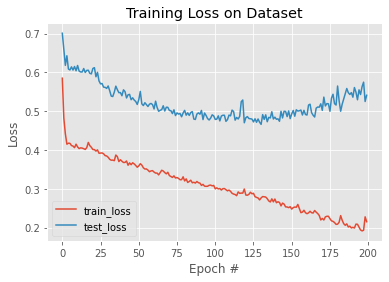

In [20]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

In [21]:

def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [22]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
    # make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

[INFO] loading up test image paths...
[INFO] load up model...


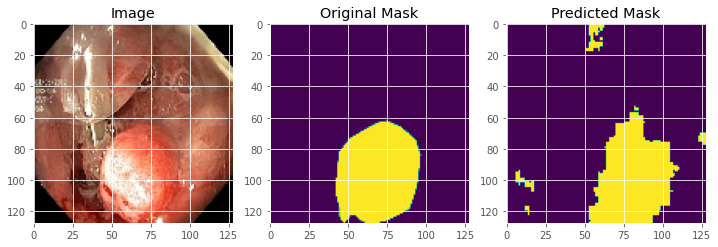

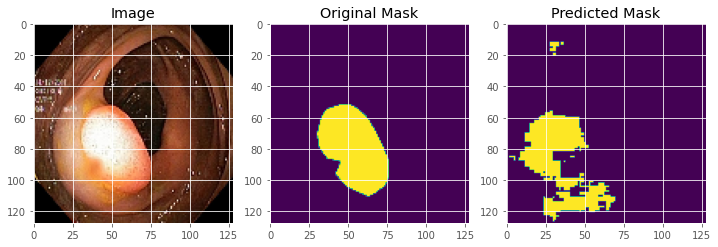

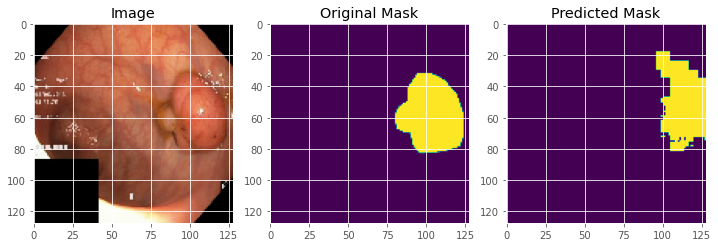

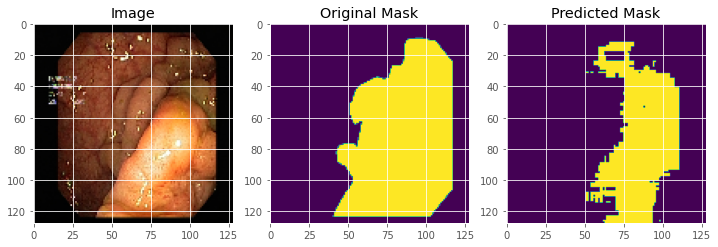

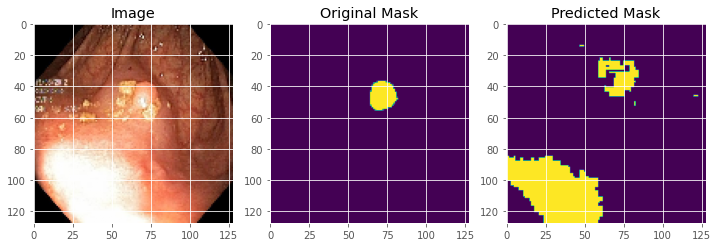

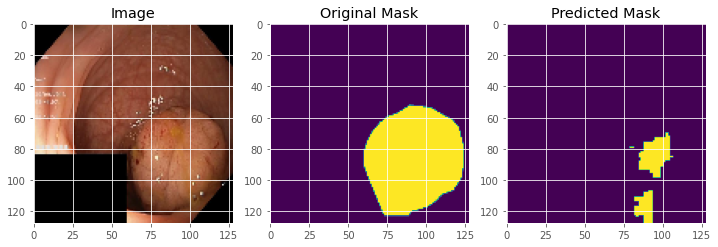

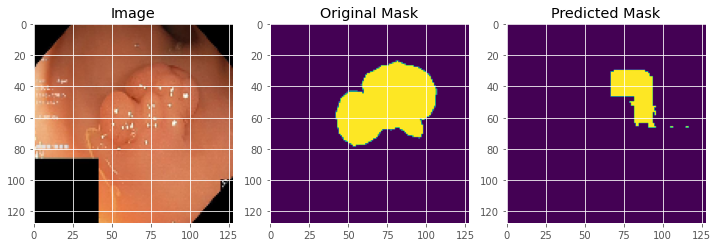

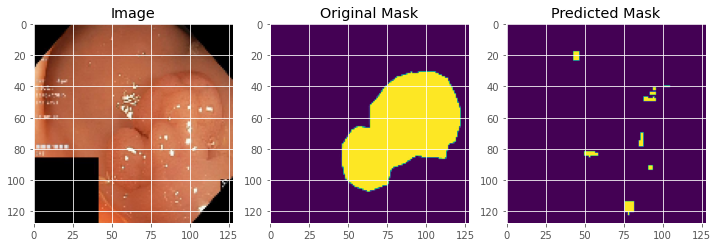

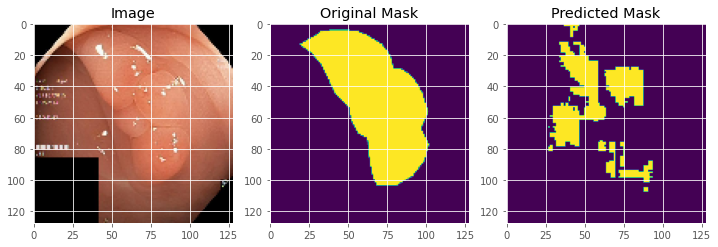

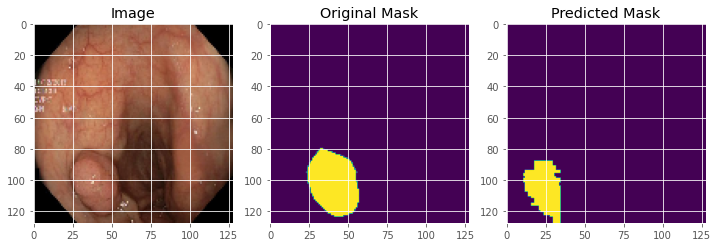

In [23]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)